# Cold Spells - AIFS
---

In the end of June 2025, South America experienced unprecedented cold temperatures. This example shows analysis of the selected parameters:
- [`z`](https://codes.ecmwf.int/grib/param-db/129) geopotential at constant pressure level 500 hPa,
- [`t`](https://codes.ecmwf.int/grib/param-db/130) temperature at 850 hPa,
- [`sf`](https://codes.ecmwf.int/grib/param-db/228144) snowfall, and
- [`msl`](https://codes.ecmwf.int/grib/param-db/151) mean sea level pressure of the **AIFS Ensemble** datasets on 1 July at 06 UTC in Argentina (34.60° S, 58.38° W).

:::{note}
[Geopotential height](https://codes.ecmwf.int/grib/param-db/156) will be calculated from geopotential, because this parameter is not part of the AIFS products.
:::

## 1. Set Up Your Environment and Find ECMWF Open Data
Open data will be downloaded from a publicly available [Amazon S3 Bucket](../datadownload/find-data.md). First, the following Python libraries need to be installed in the current Jupyter kernel:
- `ecmwf-opendata` to download data and
- `earthkit` to analyse and plot the data.

:::{seealso}
More detailed information about how to install Python packages is available on the [Retrieve Data](../datadownload/data-download.ipynb) website.
:::
If the packages are not installed yet, uncomment the code below and run it.

In [ ]:
# !pip3 install earthkit ecmwf-opendata

In [32]:
from ecmwf.opendata import Client
import earthkit.data as ekd
import earthkit.plots as ekp
import earthkit

(content:references:listParam_csa)=
### List of parameters to retrieve from open datasets
The selected values below can be modified.
- Parameters available on pressure levels:

In [2]:
PARAM_PL = ["z", "t"]
LEVELS = [500, 850]
LEVELTYPE = "pl"

DATES = [20250701, 20250702]
TIME = 6
STEPS = 0
STREAM = "enfo"
TYPE = "cf"
MODEL = "aifs-ens"

- Parameters available on a single level:

In [30]:
PARAM_SFC = ["sf", "msl"]
LEVELTYPE = "sfc"

DATES = [20250701, 20250702]
TIME = 6
STEPS = 6
STREAM = "enfo"
TYPE = "cf"
MODEL = "aifs-ens"

### Get the data using the ECMWF Open Data API

In [33]:
def get_open_data(date, time, step, stream, _type, model, param, leveltype, levelist=[]):
    client = Client(source="aws")
    list_of_files = []
    # Get the data for all dates
    for _date in DATES:
        filename = f"{model}_{''.join(param)}_{''.join(map(str, levelist))}_{_date}.grib2" if levelist else f"{model}_{''.join(param)}_{leveltype}_{_date}.grib2"
        data = client.retrieve(
            date=_date,
            time=time,
            step=step,
            stream=stream,
            type=_type,
            levtype=leveltype,
            levelist=levelist,
            param=param,
            model=model,
            target=filename
            )
        list_of_files.append(filename)
    return data, list_of_files

## 2. Geopotential at 500 hPa and temperature at 850 hPa
When using the `ls()` method, a list of all the fields in the file we downloaded will be displayed. <br>
The type `cf` indicates that we only retrieve the data of the control forecast.

In [4]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_PL,
                                    leveltype=LEVELTYPE,
                                    levelist=LEVELS)

# Select AIFS model data from 1 July 2025
ds = ekd.from_source("file", list_of_files[0])
ds.ls()

Model 'aifs-ens' does not match the client model 'ifs', using model 'aifs-ens' from retrieve
                                                                                

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,isobaricInhPa,850,20250701,600,0,cf,0,regular_ll
1,ecmf,t,isobaricInhPa,850,20250701,600,0,cf,0,regular_ll
2,ecmf,z,isobaricInhPa,500,20250701,600,0,cf,0,regular_ll
3,ecmf,t,isobaricInhPa,500,20250701,600,0,cf,0,regular_ll


:::{warning}
The following warning is displayed when we execute the above function for the very first time: “Model 'aifs-ens' does not match the client model 'ifs', using model 'aifs-ens' from retrieve”.
:::

We will use the `sel()` method to filter out the parameters and their levels that we do not want to analyse. The `describe()` method provides an overview of the selected parameter.

In [5]:
t850 = ds.sel({"level": 850, "shortName": "t"})
t850.describe("t")

shortName,t
typeOfLevel,isobaricInhPa
level,850
date,20250701
time,600
step,0
paramId,130
class,ai
stream,enfo
type,cf
experimentVersionNumber,0001


:::{caution}
For single fields, one has to use the bracket operator to fetch and access as well as modify its metadata.
:::

In [6]:
z500 = ds.sel({"level": 500, "shortName": "z"})[0]
z500.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,isobaricInhPa,500,20250701,600,0,cf,0,regular_ll


Geopotential height is calculated by dividing the geopotential by the Earth's mean gravitational acceleration, g (=9.80665 m s-2). In the ECMWF Open Charts, it is plotted in geopotential decameters. Therefore, our result also need to be divided by 10.

In [7]:
ds_gh500 = z500.values / (9.80665 * 10)

md_gh500 = z500.metadata().override(shortName="gh")
md_gh500["shortName"], md_gh500["level"]

('gh', 500)

In [8]:
gh500 = ekd.FieldList.from_array(ds_gh500, md_gh500)
gh500.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,gh,isobaricInhPa,500,20250701,600,0,cf,0,regular_ll


## 3. Snowfall and mean sea level pressure
The input values can be set [here](#content:references:listParam_csa).

In [31]:
data, list_of_files = get_open_data(date=DATES,
                                    time=TIME,
                                    step=STEPS,
                                    stream=STREAM,
                                    _type=TYPE,
                                    model=MODEL,
                                    param=PARAM_SFC,
                                    leveltype=LEVELTYPE,
                                    levelist=[])

# Select data from 1 July 2025
sf_msl = ekd.from_source("file", list_of_files[0])
sf_msl.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,sf,surface,0,20250701,600,0-6,cf,0,regular_ll
1,ecmf,msl,meanSea,0,20250701,600,6,cf,0,regular_ll


A unit of snowfall is kg/m$^2$ which corresponds to the snow depth 1 mm. <br>
The `sf` parameter gives information about total snowfall from the start of the forecast onwards. For instance, `step=6` indicates accumulated precipitation from 00 UTC until 06 UTC.

In [35]:
ds_sf = sf_msl.sel(shortName="sf")
ds_sf.describe("sf")

shortName,sf
typeOfLevel,surface
level,0
date,20250701
time,600
step,6
paramId,228144
class,ai
stream,enfo
type,cf
experimentVersionNumber,0001


We will plot mean sea level pressure data in hPa, therefore we need to divide them by 100.

In [32]:
ds_msl = sf_msl.sel(shortName="msl")
ds_msl.describe("msl")

shortName,msl
typeOfLevel,meanSea
level,0
date,20250701
time,600
step,6
paramId,151
class,ai
stream,enfo
type,cf
experimentVersionNumber,0001


In [34]:
msl = ekd.SimpleFieldList()
md = ds_msl.metadata()
v = ds_msl.to_array() / 100
for f in range(len(md)):
    msl.append(ekd.ArrayField(v[f], md[f]))
msl.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20250701,600,6,cf,0,regular_ll


## 4. 2-metre temperature less than 273.15 K
The input values can be set [here](#content:references:listParam_csa).

In [34]:
PARAM_SFC = ["2tl273"]
LEVELTYPE = "sfc"

DATES = [20250701]
TIME = 6
STEPS = 360
STREAM = "enfo"
TYPE = "ep"
MODEL = "aifs-ens"

_To be continued_

## 5. Data visualisation

The plot below shows analyses of T850 and z500 on 1 July 2025.

:::{note}
The `transform_first` keyword argument indicates that the `earthkit-plot` package will transform the points before generating the contours which speed up the process of plotting the data.
:::

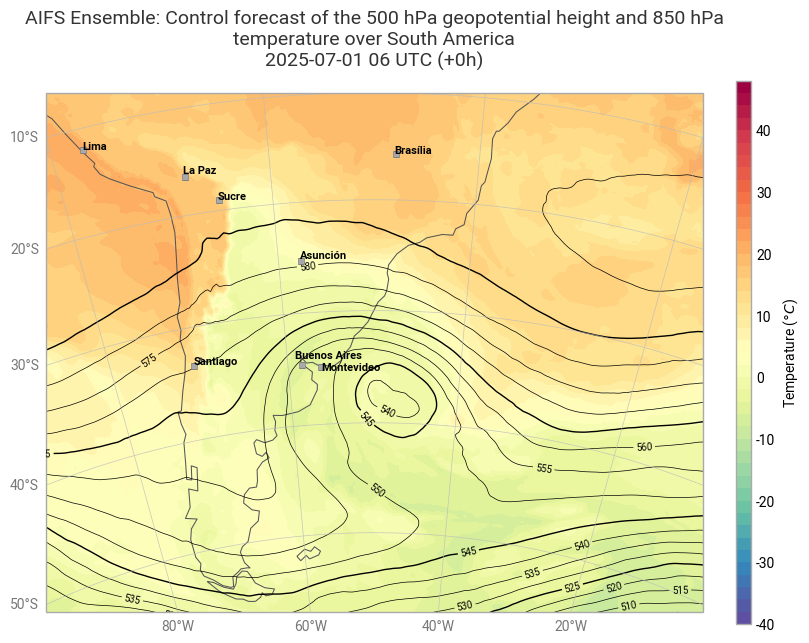

In [15]:
chart = ekp.Map(domain=[-80, -20, -55, -10])

t850_shade = ekp.styles.Style(
    colors="Spectral_r",
    levels=range(-40, 50, 2),
    units="celsius",
)

chart.contourf(t850, style=t850_shade)

chart.contour(gh500,
              levels={"step": 5, "reference": 550},
              linecolors="black",
              linewidths=[0.5, 1, 0.5, 0.5],
              labels = True,
              legend_style = None,
              transform_first=True)

chart.coastlines(resolution="low")
chart.gridlines()
chart.cities(capital_cities=True, adjust_labels=True)

chart.legend(location="right")

chart.title(
    "AIFS Ensemble: Control forecast of the 500 hPa geopotential height and 850 hPa temperature over South America\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
chart.save(f"./plots/{''.join(PARAM_PL)}_{MODEL}_{DATES[0]}{TIME}-{STEPS}h.png")
chart.show()

The plot below shows the analysis of mean sea level pressure and snowfall on 1 July 2025.

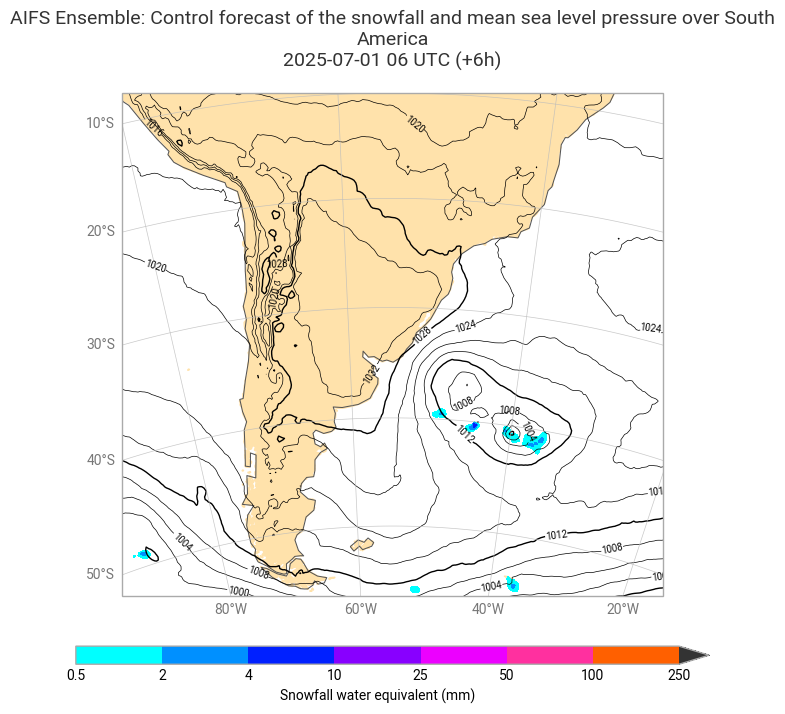

In [46]:
chart = ekp.Map(domain=[-80, -30, -55, -10])

hex_colours = ['#00ffff', '#0080ff', '#0000ff', '#d900ff', '#ff00ff', '#ff8000', '#ff0000', '#333333', ]

sf_shade = ekp.styles.Style(
    colors = hex_colours,
    levels = [0.5, 2, 4, 10, 25, 50, 100, 250],
    extend = "max",
)

chart.land(color="#ffe2ab")
chart.contourf(ds_sf, style=sf_shade)
chart.contour(msl,
              levels={"step": 4, "reference": 1000},
              linecolors="black",
              linewidths=[0.5, 1, 0.5, 0.5],
              labels = True,
              legend_style = None,
              transform_first=True)

chart.coastlines(resolution="low")
chart.gridlines()

chart.legend(location="bottom", label="{variable_name} (mm)")

chart.title(
    "AIFS Ensemble: Control forecast of the snowfall and mean sea level pressure over South America\n"
    "{base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n",
    fontsize=14, horizontalalignment="center",
)
chart.save(f"./plots/{''.join(PARAM_SFC)}_{MODEL}_{DATES[0]}{TIME}-{STEPS}h.png")
chart.show()